# RL coursework, part IV (30 pts in total)

---

**Name:** Yuen Chung, CHAN

**SN:**

---

**Due date:** *April 11th, 2024*

---

Standard UCL policy (including grade deductions) automatically applies for any late submissions.

## How to submit

When you have completed the exercises and everything has finished running, click on 'File' in the menu-bar and then 'Download .ipynb'. This file must be submitted to Moodle named as **`<studentnumber>_RL_part4.ipynb`** before the deadline above, where `<studentnumber>` is your student number.

### Objectives

#### Q.1: You will implement a number of off-policy multi-step return estimates, and answer questions about their accuracy.

#### Q.2: You will be looking at other, TD-like, updates to learn the value function. You will be asked to investigate different properties of these: e.g. convergence properties, variance of updates. This is akin to a typical analysis one would undertaken when proposing a new update rule to learn value functions.


## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np

np.set_printoptions(precision=3, suppress=1)

try:
    plt.style.use('seaborn-notebook')
except:
    plt.style.use('seaborn-v0_8-notebook')

## Q1 [11 points total]
For many concrete algorithms, we need to combine multi-step updates with off-policy corrections.  The multi-step updates are necessary for efficient learning, while the off-policy corrections are necessary to learn about multiple things at once, or to correct for a distribution mismatch (e.g., when trying to perform a policy-gradient update from logged data).

In this section, you will implement various different returns with off-policy corrections.  The next cell has two examples *without* corrections.  These examples compute equivalent returns, but compute those returns in different ways.  These are provided as reference implementations to help you.

Note that the implementations both allow for immediate bootstrapping on the current state value. This is unconventional (most literature only allows the first bootstrapping to happen after the first step), but we will use this convention in all implementations below for consistency.

In [2]:
#@title On-policy return computations

def on_policy(observations, actions, pi, mu, rewards, discounts,
              trace_parameter, v_fn):
  """Compute on-policy return recursively."""
  del mu  # The policy probabilities are ignored by this function
  del pi
  T = len(rewards)  # number of transitions
  r = rewards
  d = discounts
  l = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  G = np.zeros((T,))
  # recurse backwards to calculate returns
  for t in reversed(range(T)):
    # There are T+1 observations, but only T rewards, and the indexing here
    # for the rewards is off by one compared to the indexing in the slides
    # and in Sutton & Barto.  In other words, r[t] == R_{t+1}.
    if t == T - 1:
      G[t] = r[t] + d[t]*v[t + 1]
    else:
      G[t] = r[t] + d[t]*((1 - l)*v[t + 1] + l*G[t + 1])
  v = v[:-1]  # Remove (T+1)th observation before calculating the returns
  return (1 - l)*v + l*G


def on_policy_error_recursion(observations, actions, pi, mu, rewards, discounts,
                              trace_parameter, v_fn):
  del pi  # The target policy probabilities are ignored by this function
  del mu  # The behaviour policy probabilities are ignored by this function
  T = len(rewards)  # number of transitions
  r = rewards
  d = discounts
  l = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  errors = np.zeros((T,))

  error = 0.
  # recurse backwards to calculate errors
  for t in reversed(range(T)):
    error = r[t] + d[t]*v[t + 1] - v[t] + d[t]*l*error
    errors[t] = error
  v = v[:-1]  # Remove (T+1)th observation before calculating the returns
  return v + l*errors

### Q 1.1 [5 points]
Implement the return functions below and run the cells below that.

In [3]:
def full_importance_sampling(observations, actions, pi, mu, rewards, discounts, trace_parameter, v_fn):
    """
    Compute off-policy return with full importance-sampling corrections, so that
    the return G_t is corrected with the full importance-sampling correction of
    the rest of the trajectory.
    """
    # Shorten the variable names
    T, r, d, l = len(rewards), rewards, discounts, trace_parameter

    # Values
    v = np.array([v_fn(o) for o in observations])
    # Returns
    G = np.zeros((T,))
    # Importance-sampling correction
    c = np.zeros((T,))

    # Recurse backwards to calculate returns
    for t in reversed(range(T)):
        if t == T - 1:
            G[t] = r[t] + d[t] * v[t+1]
            c[t] = pi[t] / mu[t]  # Importance-sampling
        else:
            G[t] = r[t] + d[t] * ((1 - l)*v[t+1] + l*G[t+1])
            c[t] = pi[t] / mu[t] * c[t+1]  # Importance-sampling

    G *= c  # Apply correction
    v = v[:-1]  # Remove (T+1)th observation

    return (1 - l)*v + l*G


def per_decision(observations, actions, pi, mu, rewards, discounts, trace_parameter, v_fn):
    """
    Compute off-policy return with per-decision importance-sampling corrections.
    """
    # Shorten the variable names
    T, r, d, l = len(rewards), rewards, discounts, trace_parameter

    # Values
    v = np.array([v_fn(o) for o in observations])
    # Returns
    G = np.zeros((T,))

    # Recurse backwards to calculate returns
    for t in reversed(range(T)):
        if t == T - 1:
            G[t] = r[t] + d[t] * v[t+1]
        else:
            G[t] = r[t] + d[t] * ((1 - l)*v[t+1] + l*G[t+1])
        rho_t = pi[t] / mu[t]
        G[t] *= rho_t  # Importance-sampling correction

    v = v[:-1]  # Remove (T+1)th observation

    return (1 - l)*v + l*G


def control_variates(observations, actions, pi, mu, rewards, discounts, trace_parameter, v_fn):
    T, r, d, l = len(rewards), rewards, discounts, trace_parameter

    # Values
    v = np.array([v_fn(o) for o in observations])

    errors = np.zeros((T+1,))

    # Recurse backwards to calculate errors
    for t in reversed(range(T)):
        td_error = r[t] + d[t]*v[t+1] - v[t]
        bt_error = d[t] * l * errors[t+1]
        errors[t] = td_error + bt_error

        rho_t = pi[t] / mu[t]
        errors[t] *= rho_t

    # Remove the (T+1)th term
    v, errors = v[:-1], errors[:-1]

    return v + l*errors


def adaptive_bootstrapping(observations, actions, pi, mu, rewards, discounts, trace_parameter, v_fn):
    T, r, d = len(rewards), rewards, discounts

    # Values
    v = np.array([v_fn(o) for o in observations])
    # Adaptive trace parameter
    l = np.zeros((T,))

    errors = np.zeros((T+1,))

    # Recurse backwards to calculate errors
    for t in reversed(range(T)):
        td_error = r[t] + d[t]*v[t+1] - v[t]
        bt_error = d[t] * errors[t+1]
        errors[t] = td_error + bt_error

        rho_t = pi[t] / mu[t]
        l[t] = min(1, 1/rho_t)
        errors[t] *= rho_t
        errors[t] *= l[t]

    # Remove the (T+1)th term
    v, errors = v[:-1], errors[:-1]

    return v + errors

In [4]:
#@title (Run, don't modify) Functions to generate experience, compute values
MU_RIGHT = 0.5
PI_RIGHT = 0.9
NUMBER_OF_STEPS = 5
DISCOUNT = 0.99

def generate_experience():
  r"""Generate experience trajectories from a tabular tree MDP.

  This function will start in state 0, and will then generate actions according
  to a uniformly random behaviour policy.  When A_t == 0, the action will be to
  the left, with A_t==1, it will be to the right.  The states are nunmbered as
  depicted below:
          0
         / \
        1   2
       / \ / \
      3   4   5
         ...

  Args:
      number_of_steps: the number of total steps.
      p_right: probability of the behaviour to go right.

  Returns:
      A dictionary with elements:
        * observations (number_of_steps + 1 integers): the
          observations are just the actual (integer) states
        * actions (number_of_steps integers): actions per step
        * rewards (number_of_steps scalars): rewards per step
        * discounts (number_of_steps scalars): currently always 0.9,
          except the last one which is zero
        * mu (number_of_steps scalars): probability of selecting each
          action according to the behavious policy
        * pi (number_of_steps scalars): probability of selecting each
          action according to the target policy (here p(1) = 0.9 and
          p(0) = 0.1, where a==1 implies we go 'right')
  """
  # generate actions
  actions = np.array(np.random.random(NUMBER_OF_STEPS,) < MU_RIGHT,
                     dtype=int)
  s = 0
  # compute resulting states
  states = np.cumsum(np.arange(1, NUMBER_OF_STEPS + 1) + actions)
  states = np.array([0] + list(states))  # add start state

  # in this case, observations are just the real states
  observations = states

  # generate rewards
  rewards     = 2.*actions - 1. # -1 for left, +1 for right,
  rewards[-1] = np.sum(actions)  # extra final reward for going right

  # compute discounts
  discounts     = DISCOUNT * np.ones_like(rewards)
  discounts[-1] = 0.  # final transition is terminal, has discount=0

  # determine target and behaviour probabilities for the selected actions
  pi = np.array([1. - PI_RIGHT, PI_RIGHT])[actions] # Target probabilities
  mu = np.array([1. - MU_RIGHT, MU_RIGHT])[actions] # Behaviour probabilities

  return dict(observations=observations,
              actions=actions,
              pi=pi,
              mu=mu,
              rewards=rewards,
              discounts=discounts)

def true_v(s, pi, number_of_steps):
  """Compute true state value recursively."""
  depth = int(np.floor((np.sqrt(1 + 8*s) - 1)/2))
  position = int(s - depth*(depth+1)/2)
  remaining_steps = number_of_steps - depth
  final_reward = DISCOUNT**(remaining_steps-1)*(position + pi*remaining_steps)
  reward_per_step = pi*(+1) + (1 - pi)*(-1)
  discounted_steps = (1 - DISCOUNT**(remaining_steps - 1))/(1 - DISCOUNT)
  reward_along_the_way = reward_per_step * discounted_steps
  return reward_along_the_way + final_reward



[ 20.016 442.125 149.121   6.213   0.871]


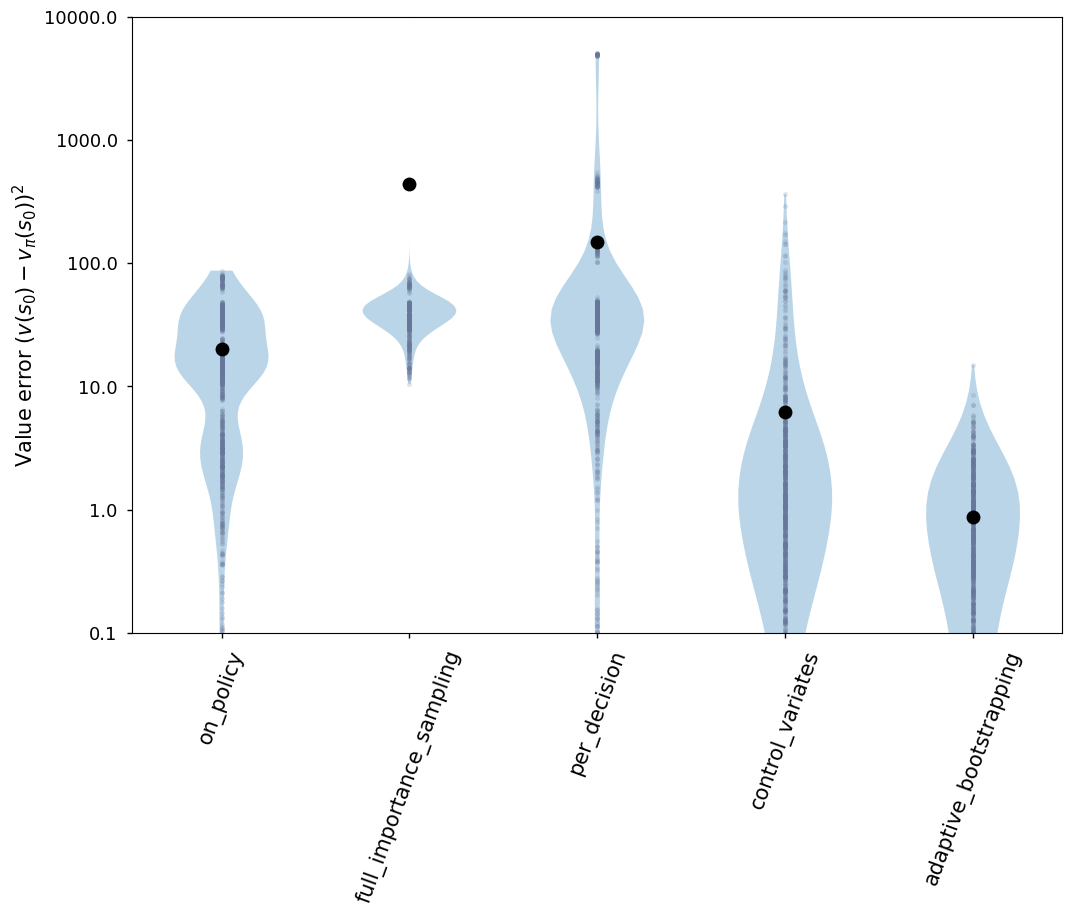

In [5]:
#@title Run experiment (don't modify)
algs = ['on_policy', 'full_importance_sampling', 'per_decision', 'control_variates', 'adaptive_bootstrapping']

# Precompute state values (for efficiency)
N = NUMBER_OF_STEPS
true_vs = [true_v(s, PI_RIGHT, N) for s in range((N+1)*(N+2)//2)]

def random_v(iteration, s):
  rng = np.random.RandomState(seed=s + iteration*10000)
  return true_vs[s] + rng.normal(loc=0, scale=1.)  # Add fixed random noise

def plot_errors(ax, errors):
  errors = np.array(errors)
  ax.violinplot(np.log10(errors), showextrema=False)
  ax.plot(range(1, len(algs)+1), np.log10(errors).T,
          '.', color='#667799', ms=7, alpha=0.2)
  ax.plot(range(1, len(algs)+1), np.log10(np.mean(errors, axis=0)),
          '.', color='#000000', ms=20)
  ax.set_yticks(np.arange(-2, 5))
  ax.set_yticklabels(10.**np.arange(-2, 5), fontsize=13)
  ax.set_ylabel("Value error $(v(s_0) - v_{\\pi}(s_0))^2$", fontsize=15)
  ax.set_xticks(range(1, len(algs)+1))
  ax.set_xticklabels(algs, fontsize=15, rotation=70)
  ax.set_ylim(-1, 4)

fig = plt.figure(figsize=(12, 8))

errors = []
estimates = []
v0 = true_vs[0]
for iteration in range(1000):
  errors.append([])
  estimates.append([])
  trajectory = generate_experience()
  for alg in algs:
    estimate = eval(alg)(**trajectory,
                        v_fn=lambda s: random_v(iteration, s),
                        trace_parameter=0.9)
    errors[-1].append((estimate[0] - v0)**2)
print(np.mean(errors, axis=0))
plot_errors(plt.gca(), errors)

Above, the distributions of mean squared value errors are shown, with the mean as a big black dot and the (1,000) individual return samples as small black dots.

### Q 1.2 [3 points]
Explain the ranking in terms of value error of the different return estimates.

> The ranking of mean squared error in a order of increasing performance:
>
> - **Full Importance Sampling**
> 
>   This approach suffers from extremely high variance when the behavior policy is very different from the target policy. Such extreme differences would affect whole trajectories as corrections are applied fully. The high variance translates to large MSE in value estimates and thus performs the worst.
> 
> - **Per-decision Importance Sampling**
> 
>   This approach attempts to reduce the variance of full importance sampling by applying corrections at each step rather than over whole trajectories. By breaking down the correction, it reduces the variance. Its performance is generally better than full importance sampling because the variance is lower, which explains its higher rank.
> 
> - **On Policy**
> 
>   On-policy learning have lower variance as it does not perform reweighing as the previous two approaches. Also, it behaves using the same policy as the data is generated. However, it might not explore the environment thorough enough since it only focus on data generated by the target policy.
> 
> - **Per-decision Importance Sampling with Control Variates**
> 
>   This approach builds on per-decision importance sampling by incorporating control variates to further suppress the variance. As the high variance of per-decision importance sampling mainly comes from extreme values of the importance sampling ratio $\rho_t$, an additional term $(1-\rho_t)v_t(S_t)$ is added to control the variance. The introduction of the 'control variate' term leads to the improvement in performance in terms of MSE by reducing the variance. 
> 
> - **Per-decision Importance Sampling with Control Variates and Adaptive Bootstrapping**
> 
>   To additionally reduce variance, the adaptive bootstrapping strategy performs bootstrapping only when $\rho_t > 1$. Hence, the sum of errors is truncated when the behavior policy happens to be less likely than the target policy. It prevents being way too "off-policy". Its best performance results from the cumulative benefits of per-decision importance sampling, control variates and adat



### Q 1.3 [3 points]
Could there be a reason to **not** choose the best return according to this ranking when learning off-policy?  Explain your answer.

> The best return is corrected using per-decision importance sampling with control variates and adaptive bootstrapping.
> 
> There are a few reasons not to choose this correction:
>
> - When bootstrapping have to be reduced significantly
>
>   As shown in lectures, bootstrapping too much might lead to divergence when using function approximation. For the function approximation to converge, other approach have to be adopted.
>
> - When the environment is simple and with short trajectories
>
>   In this case, the benefit of the approach using control variate and adaptive bootstrapping might not be necessary. Simpler methos with less computations might show comparable results.
>
> - When importance sampling is not necessary
>
>   When the behavior policy is similar to the target policy, the importance scaling might not be necessary. Simpler methods might out-perform without the added complexity.

## Q2 [19 points total]
 Consider a MDP $M = (\mathcal{S}, \mathcal{A}, p, r, \gamma)$ and a behaviour policy $\mu$. We use policy $\mu$ to generate trajectories of experience:
\begin{equation*}
    (s_{t}, a_{t}, r_{t},s_{t+1}, a_{t+1}, r_{t+1},\cdots, s_{t+n-1}, a_{t+n-1}, r_{t+n-1}, s_{t+n}, a_{t+n}) \,.
\end{equation*}
Note that this is an $n$-step sequence, starting from time $t$.

Given these partial trajectories we consider the following learning problems:




### Q2.1 [9 points]
Consider a learning update based on the following temporal difference error:
$$\delta_t = R(S_t, A_t) + \gamma R(S_{t+1}, A_{t+1}) + \gamma^2 \max_a q(S_{t+2}, a) - q(S_t, A_t)$$

Consider updating a tabular action value function with TD.

i) Does the resulting value function converge, under any initialisation of the value function? Consider an appropiate learning rate (Robbins–Monro conditions). If so, prove the convergence under infinity number of interactions with this MDP, under fixed behaviour policy $\mu$ and show its convergence point. If not, show why it diverges. (7 points)

ii) Under which conditions, would the above process converge to the optimal value function $q_*$ ? (2 points)

#### **[Answer]**

The TD error shown can be consider as a 2-step return Q learning. We will show that updating a tabular action value function $q_t$ with the given TD error using
$$
q_{t+1}(S_t, A_t) = q_t(S_t, A_t) + \alpha_t(S_t, A_t) \left[
        R(S_t, A_t) + \gamma R(S_{t+1}, A_{t+1})
        + \gamma^2 \max_a q(S_{t+2}, a)
        - q_t(S_t, A_t)
    \right] \quad
$$
converges to the optimal $q^*$ if

- The state space $\mathcal{S}$ and action space $\mathcal{A}$ are both finite.
- The Robbins-Monro conditions on $\alpha_t(s, a)$ is satisfied $\forall (s, a) \in \mathcal{S} \times \mathcal{A}$, i.e.
    $$\sum_t \alpha_t(s, a) = \infty \quad \text{and} \quad \sum_t \alpha_t^2(s, a) < \infty \quad.$$
- $\mu(a|s) > 0  \space \forall (s, a) \in \mathcal{S} \times \mathcal{A}$
- $R(s, a)$ is finite $\forall (s, a) \in \mathcal{S} \times \mathcal{A}$.
- The action value initialisation $q_0(s, a)$ is finite $\forall (s, a) \in \mathcal{S} \times \mathcal{A}$.

##### **Proof**

The proof is inspired by the convergence proof of Q-Learning in the following two references:
1. [T. Jaakkola, M. I. Jordan and S. P. Singh, "On the Convergence of Stochastic Iterative Dynamic Programming Algorithms," in Neural Computation, vol. 6, no. 6, pp. 1185-1201, Nov. 1994, doi: 10.1162/neco.1994.6.6.1185.](https://ieeexplore.ieee.org/abstract/document/6796861)
2. [Francisco S. Melo, "Convergence of Q-Learning: A Simple Proof", Institute for Systems and Robotics, Instituto Superior Técnico, Lisboa, Portugal.](http://users.isr.ist.utl.pt/~mtjspaan/readingGroup/ProofQlearning.pdf)

Firstly, we need the following theorem from stochastic approximation, the proof of which is provided in [1].

> **Theorem 1**
> A random iterative process $\Delta_{t+1}(x) = (1 - \alpha_t(x))\Delta_t(x) + \alpha_t(x)F_t(x)$ converges to zero with probability 1 under the following assumptions: 
> 1. The state space $\mathcal{X}$ of state $x$ is finite. 
> 2. $\sum_t \alpha_t(x) = \infty, \sum_t \alpha_t^2(x) < \infty$ uniformly with probability 1 $\forall x \in \mathcal{X}$.
> 3. Each state is visited infinitely often.
> 4. $\|\mathbf{E}[F_t(x)|P_t]\|_\infty \leq \kappa \| \Delta_t \|_\infty$, where $\kappa \in (0, 1)$.
> 5. $\mathrm{Var}[F_t(x)|P_t] \leq C(1+\|\Delta_t\|_\infty)^2$, where $C$ is some constant.
> 
> Here $P_t$ stands for the trajectories up to (including) time step $t$.

Note that the theorem is slightly modified from that in [1] as the original theorem is more powerful than we need in this proof.

The proof of convergence now follows by relating our learning algorithm to the stochastic process defined by Theorem 1.

The update on $q$ according to the given TD error can be written as
$$
q_{t+1}(S_t, A_t) = (1 - \alpha_t) q_t(S_t, A_t) + \alpha_t \left[
        R(S_t, A_t) + \gamma R(S_{t+1}, A_{t+1})
        + \gamma^2 \max_a q(S_{t+2}, a)
    \right] \quad.
$$
Subtracting the optimal Q-function $q^*(S_t, A_t)$ from both sides yields
$$
\Delta_{t+1}(S_t, A_t) = (1 - \alpha_t) \Delta_t(S_t, A_t) + \alpha_t \left[
        R(S_t, A_t) + \gamma R(S_{t+1}, A_{t+1})
        + \gamma^2 \max_a q(S_{t+2}, a)
        - q^*(S_t, A_t)
    \right] \quad ,
$$
where $\Delta_t(\cdot) = q_t(\cdot) - q^*(\cdot)$.

To use Theorem 1, we define
$$
F_t(S_t, A_t) = R(S_t, A_t) + \gamma R(s', a')
        + \gamma^2 \max_{a''} q_t(s'', a'')
        - q^*(S_t, A_t)
    \quad .
$$

At this point, each $(s, a)$ pair correspond to a state $x$ in Theorem 1. To fulfill condition 3 in Theorem 1, the behavior policy must satisfy
$$
\mu(a | s) > 0 \qquad \forall s \in \mathcal{S}, a \in \mathcal{A}
$$

For $\Delta_t$ to converge to zero (i.e. $q_t \rightarrow q^*$), we have to show that $F_t(S_t, A_t)$ have the required properties on its expected value and variance.

- The max norm of the expected value of $F_t$ is bounded
    $$
    \begin{align*}
    \mathbb{E}[F_t(S_t, A_t) | P_t]    
    & = \mathbb{E}_{s', a', s''} \left[
            R(S_t, A_t) + \gamma R(s', a')
            + \gamma^2 \max_{a''} q_t(s'', a'')
            - q^*(S_t, A_t)
        \right]  \\
    & = R(S_t, A_t) + 
        \mathbb{E}_{s', a', s''} \left[
            \gamma R(s', a')
            + \gamma^2 \max_{a''} q_t(s'', a'')
        \right]
        - q^*(S_t, A_t) \\
    & = R(S_t, A_t) 
        + \gamma \sum_{s', a'} p(s'|S_t, A_t) \mu(a'|s')\left[
            R(s', a') + \gamma \sum_{s''} p(s''|s', a') \max_{a''}q_t(s'', a'')
        \right]  
        - q^*(S_t, A_t) \\
    & = R(S_t, A_t) 
        + \gamma \sum_{s', a'} p(s'|S_t, A_t) \mu(a'|s') (\mathcal{T_Q^* }q_t)(s', a')
        - q^*(S_t, A_t) \\
    & \leq R(S_t, A_t) 
        + \gamma \sum_{s'} p(s'|S_t, A_t) \max_{a'} (\mathcal{T_Q^*}q_t)(s', a')
        - q^*(S_t, A_t) \\
    & = (\mathcal{T_Q^*}(\mathcal{T_Q^*}q_t))(S_t, A_t)
        - q^*(S_t, A_t) \\
    \end{align*}
    $$
    where $\mathcal{T_Q^*}$ is the Bellman Optimality Operator defined as
    $$
    (\mathcal{T_Q^*}f)(s, a) = r(s, a) + \gamma \sum_{s'} p(s'|s, a) \max_{a'} f(s', a')  \qquad \forall f \in \mathcal{Q}: \mathcal{S} \times \mathcal {A} \rightarrow \mathbb{R}
    \quad .
    $$
    Next, we utilise the properties of the operator.
    $$
    \begin{align*}
    ||\mathbb{E}[F_t | P_t]||_\infty 
    & \leq || \mathcal{T_Q^*}(\mathcal{T_Q^*}q_t) - q^* ||_\infty \\
    & = || \mathcal{T_Q^*}(\mathcal{T_Q^*}q_t) - \mathcal{T_Q^*}q^* ||_\infty && (q^* \text{ is a fixed point of } \mathcal{T_Q^*}) \\
    & \leq \gamma || \mathcal{T_Q^*}q_t - q^* ||_\infty && (\mathcal{T_Q^*} \text{ is } \gamma\text{-contraction w.r.t } ||\cdot||_\infty) \\
    & = \gamma || \mathcal{T_Q^*}q_t - \mathcal{T_Q^*}q^* ||_\infty && (q^* \text{ is a fixed point of } \mathcal{T_Q^*}) \\
    & \leq \gamma^2 || q_t - q^* ||_\infty && (\mathcal{T_Q^*} \text{ is } \gamma\text{-contraction w.r.t } ||\cdot||_\infty) \\
    & = \gamma^2 || \Delta_t||_\infty
    \end{align*}
    $$
    Hence, the criterion on the expected value is satisfied without further assumption.

- The variance of $F_t$ is bounded

    The variance is given by
    $$
    \begin{align*}
    \text{Var}[F_t(S_t, A_t)|P_t]
    & = \text{Var}\left[
            R(S_t, A_t) + \gamma R(s', a')
            + \gamma^2 \max_{a''} q_t(s'', a'')
            - q^*(S_t, A_t)
            \Big| P_t
        \right] \\
    \end{align*}
    $$
    Note that $q^*(S_t, A_t)$ is deterministic as $(S_t, A_t)$ is contained in $P_t$. We have $\text{Var}[q^*(S_t, A_t)]=0$ and obtain
    $$
    \begin{align*}
    \text{Var}[F_t(S_t, A_t)|P_t]
    & = \text{Var}\left[
            R(S_t, A_t) + \gamma R(s', a')
            + \gamma^2 \max_{a''} q_t(s'', a'')
            \Big| P_t
        \right] \\
    \end{align*}
    $$
    As long as $R(s, a)$ and $q_t(s, a)$ is finite for all pairs of $(s, a)$, it is trivial that
    $$
    \text{Var}[F_t(S_t, A_t)|P_t] \leq C(1 + ||\Delta_t||_\infty)^2
    $$
    for some $C$. It follows that $q_t(s, a)$ is finite if its initialisation and $R(s, a)$ are finite.

Therefore, the proof for conditions on convergence is concluded.

### Q2.2 [10 points]

Consider the same questions now for the following temporal difference error
\begin{equation}
        \delta_t = r(S_{t},A_{t}) + \gamma \frac{\pi(A_{t+1}|S_{t+1})}{\mu(A_{t+1}|S_{t+1})} \left[ r(S_{t+1},A_{t+1}) + \gamma \max_{a} q(S_{t+2},a) \right] - q(S_t, A_t)
\end{equation}

where $\pi(a|s) \in \arg\max_a q(s,a), \forall s,a \in \mathcal{A} \times \mathcal{S}$ and consider the behaviour policy to be either:

  a. $\mu(a|s) \in \arg\max_a q(s,a), \forall s,a \in \mathcal{A} \times \mathcal{S}$,
  
  b. $\mu(a|s) = \frac{1}{|\mathcal{A}|}$ (uniformly random policy).

Answer the below two questions for **both choices** of the behaviour policy $\mu$:
* i)  Does updating a tabular action value function with this TD error converge to the optimal value function $q_*$? Consider an appropiate learning rate (Robbins–Monro conditions). If so, prove this convergence under infinity number of interaction with this MDP, under behaviour policy $\mu$. If not, show why it diverges or alternatively convergence to a different solution. (4 points)
* ii) How does the variance of this update compare to the one induced by the error in Q5.1? (3 points).
* iii) Can you propose a different behaviour policy that achieves a lower variance than any of the choices we considered for $\mu$? Prove that your behaviour policy achieve this. Argue why, if that is not possible. (3 points)

#### **[Answer]**

##### **(i) - Convergence**

- **a.** $\mu(a|s) \in \arg\max_a q(s,a) \quad \forall s,a \in \mathcal{A} \times \mathcal{S}$
  
    To keep the correction factor $\pi(a|s)/\mu(a|s)$ finite, $\mu(s, a)$ has to be non-zero for all $(s, a) \in \mathcal{S} \times \mathcal{A}$.
    Hence, we have
    $$ 
    \mu(a | s) > 0 \qquad \forall s \in \mathcal{S}, a \in \mathcal{A}
    $$
    due to the nature of probability. Also, the correction factor reduces to 1 as the target policy and behavior policy are the same.

    The conditions of convergence and its proof follow from that in Q2.1 as the TD error and update rule are the same.

- **b.** $\mu(a|s) = 1/|\mathcal{A}|$

    The proof of convergence and conditions basically follows the same thought in Q2.1, where $F_t(S_t, A_t)$ becomes
    $$
    F_t(S_t, A_t) = R(S_t, A_t) + \frac{\pi(a'|s')}{\mu(a'|s')}[
                \gamma R(s', a')
                + \gamma^2 \max_{a''} q_t(s'', a'')
            ]
            - q^*(S_t, A_t)
        \quad .
    $$
    We would verify the required properties on its expected value and variance.
    - The max norm of the expected value of $F_t$ is bounded
        $$
        \begin{align*}
        \mathbb{E}[F_t(S_t, A_t) | P_t]    
        & = \mathbb{E}_{s', a', s''} \left[
                R(S_t, A_t) + \frac{\pi(a'|s')}{\mu(a'|s')} [\gamma R(s', a')
                + \gamma^2 \max_{a''} q_t(s'', a'')]
                - q^*(S_t, A_t)
            \right]  \\
        & = R(S_t, A_t) + 
            \gamma \mathbb{E}_{s', a', s''} \left[ \frac{\pi(a'|s')}{\mu(a'|s')} [
                R(s', a')
                + \gamma \max_{a''} q_t(s'', a'')]
            \right]
            - q^*(S_t, A_t) \\
        & = R(S_t, A_t) 
            +  \gamma \sum_{s', a'} p(s'|S_t, A_t) \mu(a'|s')
                \frac{\pi(a'|s')}{\mu(a'|s')} \left[
                R(s', a') + \gamma \sum_{s''} p(s''|s', a') \max_{a''}q_t(s'', a'')
            \right]  
            - q^*(S_t, A_t) \\
        & = R(S_t, A_t) 
            +  \gamma \sum_{s', a'} p(s'|S_t, A_t) \pi(a'|s') \left[
                R(s', a') + \gamma \sum_{s''} p(s''|s', a') \max_{a''}q_t(s'', a'')
            \right]  
            - q^*(S_t, A_t) \\
        & = R(S_t, A_t) 
            + \gamma \sum_{s', a'} p(s'|S_t, A_t) \pi(a'|s') (\mathcal{T_Q^* }q_t)(s', a')
            - q^*(S_t, A_t) \\

        & \leq R(S_t, A_t) 
            + \gamma\sum_{s'} p(s'|S_t, A_t) \max_{a'} (\mathcal{T_Q^*}q_t)(s', a')
            - q^*(S_t, A_t) \\
        & = (\mathcal{T_Q^*}(\mathcal{T_Q^*}q_t))(S_t, A_t)
            - q^*(S_t, A_t) \\
        \end{align*}
        $$
        The remaining part is the same as that in Q2.1 without any further assumption.

    - The variance of $F_t$ is bounded
        The variance is given by
        $$
        \begin{align*}
        \text{Var}[F_t(S_t, A_t)|P_t]
        & = \text{Var}\left[
                R(S_t, A_t) + |\mathcal{A}|\pi(a'|s') [\gamma R(s', a')
                + \gamma^2 \max_{a''} q_t(s'', a'')]
                - q^*(S_t, A_t)
                \Big| P_t
            \right] \\
        \end{align*}
        $$
        Note that $q^*(S_t, A_t)$ is deterministic as $(S_t, A_t)$ is contained in $P_t$. We have $\text{Var}[q^*(S_t, A_t)]=0$ and obtain
        $$
        \begin{align*}
        \text{Var}[F_t(S_t, A_t)|P_t]
        & = \text{Var}\left[
                R(S_t, A_t) + |\mathcal{A}|\pi(a'|s') [\gamma R(s', a')
                + \gamma^2 \max_{a''} q_t(s'', a'')]
                \Big| P_t
            \right] \\
        \end{align*}
        $$
        Given that $\pi(a'|s') \in [0, 1]$ due to the nature of probability. As long as $R(s, a)$ and $q_t(s, a)$ is finite for all pairs of $(s, a)$, it is trivial that
        $$
        \text{Var}[F_t(S_t, A_t)|P_t] \leq C(1 + ||\Delta_t||_\infty)^2
        $$
        for some $C$. It follows that $q_t(s, a)$ is finite if its initialisation and $R(s, a)$ are finite.

    To conclude, the update rule using this TD error converges to the optimal $q^*$ if
    - The state space $\mathcal{S}$ and action space $\mathcal{A}$ are both finite.
    - The Robbins-Monro conditions on $\alpha_t(s, a)$ is satisfied $\forall (s, a) \in \mathcal{S} \times \mathcal{A}$, i.e.
        $$\sum_t \alpha_t(s, a) = \infty \quad \text{and} \quad \sum_t \alpha_t^2(s, a) < \infty \quad.$$
    - $\mu(a|s) > 0 \space \forall (s, a) \in \mathcal{S} \times \mathcal{A}$
    - $R(s, a)$ is finite $\forall (s, a) \in \mathcal{S} \times \mathcal{A}$.
    - The action value initialisation $q_0(s, a)$ is finite $\forall (s, a) \in \mathcal{S} \times \mathcal{A}$.
    
##### **(ii) - Variance comparison with Q2.1**

- **a.** $\mu(a|s) \in \arg\max_a q(s,a) \quad \forall s,a \in \mathcal{A} \times \mathcal{S}$
  
  As the update rule is same as Q2.1, the variance is also the same.

- **b.** $\mu(a|s) = 1/|\mathcal{A}|$

    To compare the variance of the two different errors, we denote the update in Q2.1 as
    $$
    \delta_t^{(1)} = r(S_t, A_t) + \gamma r(S_{t+1}, A_{t+1}) 
    + \gamma^2 \max_a q_t(S_{t+2}, a) - q_t(S_t, A_t)
    $$
    and the update in Q2.2b (this part) as
    $$
    \delta_t^{(2)} = r(S_t, A_t) + \frac{\pi(A_t+1|S_{t+1})}{\mu(A_t+1|S_{t+1})} [\gamma r(S_{t+1}, A_{t+1}) 
    + \gamma^2 \max_a q_t(S_{t+2}, a)] - q_t(S_t, A_t) \quad.
    $$
    In case of ***off-policy*** update according to the behaviour policy $\mu(a|s)$, the expectations of $\delta_t^{(1)}$ and $\delta_t^{(2)}$ are given by
    $$
    \begin{align*}
    \mathbb{E}_\mu[\delta_t^{(1)} | P_t]
    & = r(S_t, A_t) - q_t(S_t, A_t) + \gamma \sum_{s'} p(s'|S_t, A_t) \sum_{a'}\mu(a'|s') \mathbb{E}_{s''|s'}[G_{t+1}(s', a')] \\

    \mathbb{E}_\mu[\delta_t^{(2)} | P_t]
    & = r(S_t, A_t) - q_t(S_t, A_t) + \gamma \sum_{s'} p(s'|S_t, A_t) \sum_{a'}\pi(a'|s') \mathbb{E}_{s''|s'}[G_{t+1}(s', a')]
    \end{align*}
    $$
    where
    $$
    G_{t+1}(s', a') = r(s', a') + \gamma \max_{a''} q_t(s'', a'')
    $$
    It is observed that the two expectations are different only in the policy of sampling action $a'$ at state $s'$. In general, no strict comparison of these two expectations values can be performed as it depends on the Markov process, which applies to the variance as well.

    On the other hand, by inspecting the expression of $\mathbb{E}_\mu[\delta_t^{(2)}|P_t]$, one can notice that it is exactly the same as $\mathbb{E}_\pi[\delta_t^{(1)}|P_t]$, i.e. the expectation value of the ***on-policy*** update using the error in Q2.1.

    Hence, one can compare the variance of on-policy update using $\delta_t^{(1)}$ and the off-policy update using $\delta_t^{(2)}$. In particular, we can focus on comparing the variance of terms
    $$
    G_{t+1}(S_{t+1}, A_{t+1})
    \quad \text{and} \quad 
    \frac{\pi(a'|s')}{\mu(a'|s')}G_{t+1}(S_{t+1}, A_{t+1})
    \quad ,
    $$
    where the two updates differ from each other. Using the fact that these terms have the same mean, we obtain
    $$
    \begin{align*}
    & \mathrm{Var}_\mu[\frac{\pi(a'|s')}{\mu(a'|s')}G_{t+1}(S_{t+1}, A_{t+1})|P_t] - \mathrm{Var}_\pi[{\mu(a'|s')}G_{t+1}(S_{t+1}, A_{t+1})|P_t] \\
    & = \mathbb{E}_\mu[\left( \frac{\pi(a'|s')}{\mu(a'|s')} G_{t+1}(S_{t+1}, A_{t+1}) \right)^2 | P_t] 
        - \mathbb{E}_\pi[\left( G_{t+1}(S_{t+1}, A_{t+1}) \right)^2 | P_t] \\
    & = \sum_{s'} p(s'|S_t, A_t) \sum_{a'} \frac{\pi(a'|s')^2}{\mu(a'|s')} \mathbb{E}_{s''|s'}[G_{t+1}(s', a')^2]
        - \sum_{s'} p(s'|S_t, A_t) \sum_{a'} \pi(a'|s') \mathbb{E}_{s''|s'}[G_{t+1}(s', a')^2] \\
    & = \sum_{s'} p(s'|S_t, A_t) \sum_{a'} \pi(a'|s') \mathbb{E}_{s''|s'}[G_{t+1}(s', a')^2] \left( \frac{\pi(a'|s')}{\mu(a'|s')}  - 1 \right)
    \end{align*}
    $$
    Remember that $\pi$ is a greedy policy and $\mu$ is a uniform policy, we can classify the terms in the summation according to the two situations of the greedy policy:
    - $\pi(a' | s') = 0$
        When the action $a'$ is not a greedy action in state $s'$, the policy returns probability of zero and so the term in summation becomes zero.
    - $\pi(a' | s') > 0$
        When the action $a'$ is a greedy action in state $s'$, the policy is greater than zero. Since the maximum number of greedy action in a state is the size of the action space, we have
        $$
            \pi(a'| s') \geq \frac{1}{|\mathcal{A}|} 
            \Rightarrow
            \frac{\pi(a'| s')}{\mu(a'|s')} = |\mathcal{A}| \cdot \pi(a'| s')
            \geq 1
        $$
        Thus, the term in summation is also greater than or equal to zero.

    To conclude, the difference in variance is always greater than or equal to zero. The variance of update in this part is expected to be higher than that in Q5.1.

##### **(iii) - Behaviour policy with lower variance**

To achieve lower variance, $\mu$ can a policy that acts mostly greedy, for example a $\epsilon$-greedy policy or a softmax policy on action values. These policies allow infinite exploration of each action in each state. Thus, the predicted action value keeps improving and becomes more accurate. Conceptually, the rewards received would be more stable and less variable due to the higher confidence in action value estimates.